# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.calibration.fine_amplitude import FineXAmplitude, FineSXAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.8042610015162062+0j), sigma=80, beta=-0.6716031904518691, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8043+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [7]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_over)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

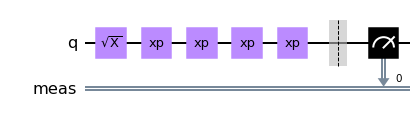

In [8]:
amp_cal.circuits(backend)[5].draw(output="mpl")

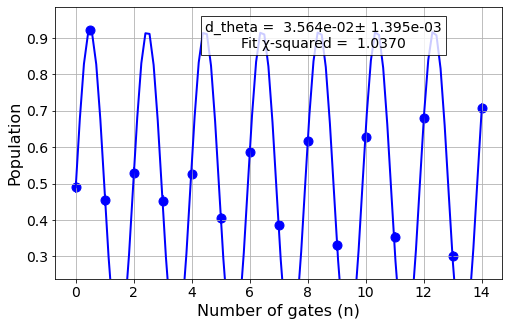

In [9]:
data_over = amp_cal.run(backend)

In [10]:
result = data_over.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.86586742,  0.03563788,  0.4900245 ]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01842502, 0.00139453, 0.00390942]),
 'pcov': array([[3.39481348e-04, 1.42731634e-05, 3.06673071e-05],
        [1.42731634e-05, 1.94472528e-06, 1.09137898e-06],
        [3.06673071e-05, 1.09137898e-06, 1.52835892e-05]]),
 'reduced_chisq': 1.037030901412029,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [11]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.036 rad.
Thus, scale the 0.8123+0.0000j pulse amplitude by 0.989 to obtain 0.80319+0.00000j.
Amplitude reported by the backend 0.8043+0.0000j.


### Detect an under-rotated pulse

In [12]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [13]:
amp_cal = FineXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=xp_under)

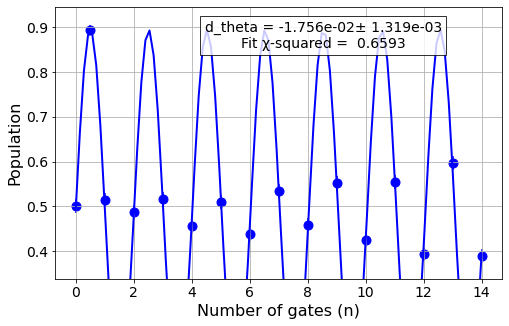

In [14]:
data_under = amp_cal.run(backend)

In [15]:
result = data_under.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.80612839, -0.01755955,  0.49150515]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.02080441, 0.00131879, 0.00401208]),
 'pcov': array([[ 4.32823492e-04, -1.01573736e-05,  3.21764291e-05],
        [-1.01573736e-05,  1.73920128e-06, -1.01553784e-06],
        [ 3.21764291e-05, -1.01553784e-06,  1.60967947e-05]]),
 'reduced_chisq': 0.6592788476952305,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [16]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.018 rad.
Thus, scale the 0.7962+0.0000j pulse amplitude by 1.006 to obtain 0.80069+0.00000j.
Amplitude reported by the backend 0.8043+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [17]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [18]:
amp_cal = FineSXAmplitude(qubit)
amp_cal.set_experiment_options(schedule=x90p)

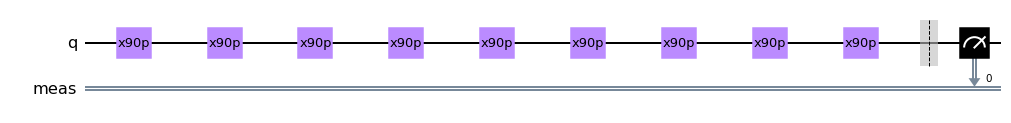

In [19]:
amp_cal.circuits(backend)[5].draw(output="mpl")

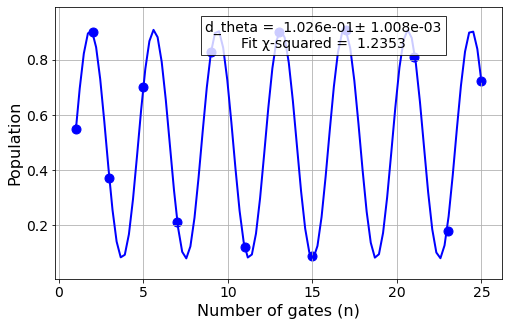

In [20]:
data_x90p = amp_cal.run(backend)

In [21]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.82973823,  0.10259436,  0.49394963]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00766172, 0.00100755, 0.00321905]),
 'pcov': array([[ 5.87019194e-05, -8.97671667e-07,  5.27968360e-06],
        [-8.97671667e-07,  1.01515825e-06,  3.55261960e-07],
        [ 5.27968360e-06,  3.55261960e-07,  1.03623113e-05]]),
 'reduced_chisq': 1.2352975354708655,
 'dof': 10,
 'xrange': [1.0, 25.0],
 'quality': 'computer_good',
 'success': True}

In [22]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.103 rad.
Thus, scale the 0.4021+0.0000j pulse amplitude by 0.939 to obtain 0.37748+0.00000j.
Amplitude reported by the backend 0.3703-0.0763j.


Let's rerun this calibration using the updated value of the amplitude of the pi-half pulse.

In [23]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [24]:
amp_cal.set_experiment_options(schedule=x90p)

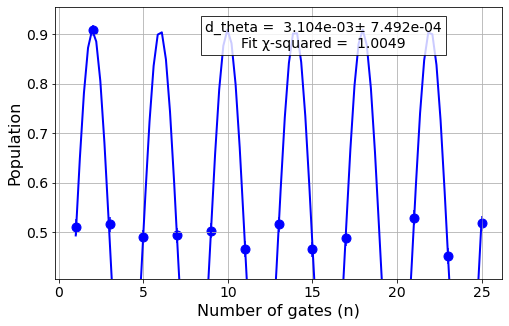

In [25]:
data_x90p = amp_cal.run(backend)

In [26]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.83490785,  0.00310367,  0.49173396]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.02016155, 0.0007492 , 0.00458066]),
 'pcov': array([[ 4.06488067e-04,  2.63899887e-07,  4.19708459e-05],
        [ 2.63899887e-07,  5.61293243e-07, -4.65433255e-07],
        [ 4.19708459e-05, -4.65433255e-07,  2.09824342e-05]]),
 'reduced_chisq': 1.0049305678390046,
 'dof': 10,
 'xrange': [1.0, 25.0],
 'quality': 'computer_good',
 'success': True}

In [27]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.003 rad.
Thus, scale the 0.3775+0.0000j pulse amplitude by 0.998 to obtain 0.37673+0.00000j.
Amplitude reported by the backend 0.3703-0.0763j.
